## More Feature extraction and some other classifiers

Import useful sklearn kits and other functions

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from time import time

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelBinarizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import Perceptron
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import RidgeClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.extmath import density
from sklearn import metrics

from sklearn.model_selection import train_test_split

#---------------
use_hashing = False
select_chi2 = False
n_features = 2 ** 16
print_top10 = False
print_report = True
print_cm = True

###########################################
# read in data
trainall_df = pd.read_csv("../input/train.csv")

# split a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(trainall_df.text, trainall_df.author, test_size = 0.2, random_state = 1)
# y_train = LabelBinarizer().fit_transform(y_train)
# y_test = LabelBinarizer().fit_transform(y_test)
print(y_train.shape)
print(y_test.shape)


(15663,)
(3916,)


Data pre-processing and extract features(use Vectorizer)

In [2]:
# extract features
print("Extracting features from the training data using a sparse vectorizer")
t0 = time()
if use_hashing:
    vectorizer = HashingVectorizer(stop_words='english', alternate_sign=False,
                                   n_features=n_features)
    X_train = vectorizer.transform(X_train)
else:
    vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.5,
                                 stop_words='english')
    X_train = vectorizer.fit_transform(X_train)

duration = time() - t0
print("done in %fs" % (duration))
print("n_samples: %d, n_features: %d" % X_train.shape)
print()

print("Extracting features from the test data using the same vectorizer")
t0 = time()
X_test = vectorizer.transform(X_test)
duration = time() - t0
print("done in %fs" % (duration))
print("n_samples: %d, n_features: %d" % X_test.shape)
print()

if use_hashing:
    feature_names = None
else:
    feature_names = vectorizer.get_feature_names()

# use chi2 or not
if select_chi2:
    print("Extracting %d best features by a chi-squared test" %
          opts.select_chi2)
    t0 = time()
    ch2 = SelectKBest(chi2, k=select_chi2)
    X_train = ch2.fit_transform(X_train, y_train)
    X_test = ch2.transform(X_test)
    if feature_names:
        # keep selected feature names
        feature_names = [feature_names[i] for i
                         in ch2.get_support(indices=True)]
    print("done in %fs" % (time() - t0))
    print()

if feature_names:
    feature_names = np.asarray(feature_names)

target_names = ['EAP','HPL','MWS']
    
def trim(s):
    """Trim string to fit on terminal (assuming 80-column display)"""
    return s if len(s) <= 80 else s[:77] + "..."

Extracting features from the training data using a sparse vectorizer
done in 0.801692s
n_samples: 15663, n_features: 22759

Extracting features from the test data using the same vectorizer
done in 0.227835s
n_samples: 3916, n_features: 22759



 The benchmark function

In [3]:
def benchmark(clf):
    print('_' * 80)
    print("Training: ")
    print(clf)
    t0 = time()
    clf.fit(X_train, y_train)
    train_time = time() - t0
    print("train time: %0.3fs" % train_time)

    t0 = time()
    pred = clf.predict(X_test)
    test_time = time() - t0
    print("test time:  %0.3fs" % test_time)

    score = metrics.accuracy_score(y_test, pred)
    print("accuracy:   %0.3f" % score)

    if hasattr(clf, 'coef_'):
        print("dimensionality: %d" % clf.coef_.shape[1])
        print("density: %f" % density(clf.coef_))

        if print_top10 and feature_names is not None:
            print("top 10 keywords per class:")
            for i, label in enumerate(target_names):
                top10 = np.argsort(clf.coef_[i])[-10:]
                print(trim("%s: %s" % (label, " ".join(feature_names[top10]))))
        print()

    if print_report:
        print("classification report:")
        print(metrics.classification_report(y_test, pred,
                                            target_names=target_names))

    if print_cm:
        print("confusion matrix:")
        print(metrics.confusion_matrix(y_test, pred))

    print()
    clf_descr = str(clf).split('(')[0]
    return clf_descr, score, train_time, test_time

Ridge Classifier
________________________________________________________________________________
Training: 
RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
        max_iter=None, normalize=False, random_state=None, solver='sag',
        tol=0.01)
train time: 0.884s
test time:  0.002s
accuracy:   0.805
dimensionality: 22759
density: 1.000000

classification report:
             precision    recall  f1-score   support

        EAP       0.77      0.85      0.81      1530
        HPL       0.84      0.76      0.80      1144
        MWS       0.83      0.79      0.81      1242

avg / total       0.81      0.80      0.80      3916

confusion matrix:
[[1304  104  122]
 [ 193  865   86]
 [ 200   59  983]]

Perceptron
________________________________________________________________________________
Training: 
Perceptron(alpha=0.0001, class_weight=None, eta0=1.0, fit_intercept=True,
      max_iter=500, n_iter=None, n_jobs=1, penalty=None, random_state=0,
      shu

train time: 11.182s
test time:  0.002s
accuracy:   0.796
dimensionality: 22759
density: 0.536960

classification report:
             precision    recall  f1-score   support

        EAP       0.75      0.86      0.80      1530
        HPL       0.83      0.75      0.79      1144
        MWS       0.83      0.76      0.80      1242

avg / total       0.80      0.80      0.80      3916

confusion matrix:
[[1310  104  116]
 [ 208  862   74]
 [ 218   77  947]]

NearestCentroid (aka Rocchio classifier)
________________________________________________________________________________
Training: 
NearestCentroid(metric='euclidean', shrink_threshold=None)
train time: 0.046s
test time:  0.003s
accuracy:   0.738
classification report:
             precision    recall  f1-score   support

        EAP       0.72      0.77      0.74      1530
        HPL       0.71      0.74      0.73      1144
        MWS       0.80      0.70      0.75      1242

avg / total       0.74      0.74      0.74      3916

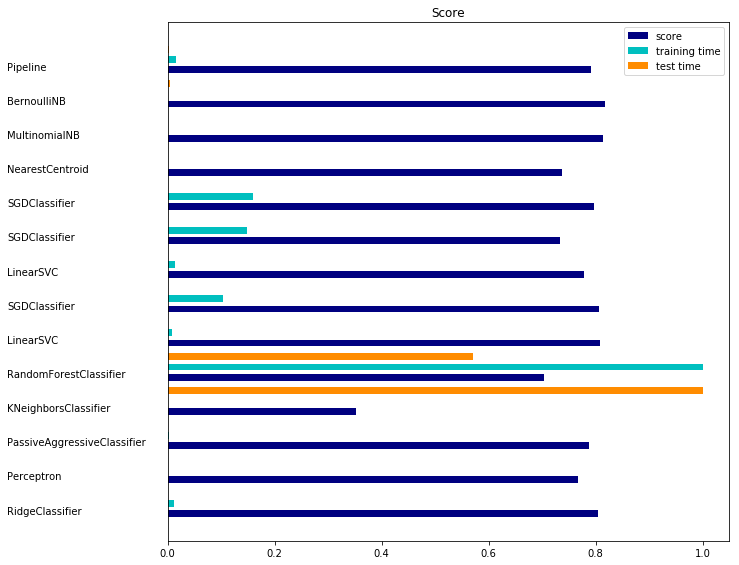

In [4]:
results = []
for clf, name in (
       # (RidgeClassifier(tol=1e-2, solver="lsqr"), "Ridge Classifier"),
        (RidgeClassifier(tol=1e-2, solver="sag"), "Ridge Classifier"),
        (Perceptron(tol=1e-2,max_iter=500), "Perceptron"),
        (PassiveAggressiveClassifier(tol=1e-2,max_iter=500), "Passive-Aggressive"),
        (KNeighborsClassifier(n_neighbors=10), "kNN"),
        (RandomForestClassifier(n_estimators=100), "Random forest")):
    print('=' * 80)
    print(name)
    results.append(benchmark(clf))

for penalty in ["l2", "l1"]:
    print('=' * 80)
    print("%s penalty" % penalty.upper())
    # Train Liblinear model
    results.append(benchmark(LinearSVC(penalty=penalty, dual=False,
                                       tol=1e-3)))

    # Train SGD model
    results.append(benchmark(SGDClassifier(alpha=.0001, max_iter=500,
                                           penalty=penalty)))

# Train SGD with Elastic Net penalty
print('=' * 80)
print("Elastic-Net penalty")
results.append(benchmark(SGDClassifier(alpha=.0001, max_iter=500,
                                       penalty="elasticnet")))

# Train NearestCentroid without threshold
print('=' * 80)
print("NearestCentroid (aka Rocchio classifier)")
results.append(benchmark(NearestCentroid()))

# Train sparse Naive Bayes classifiers
print('=' * 80)
print("Naive Bayes")
results.append(benchmark(MultinomialNB(alpha=.01)))
results.append(benchmark(BernoulliNB(alpha=.01)))

print('=' * 80)
print("LinearSVC with L1-based feature selection")
# The smaller C, the stronger the regularization.
# The more regularization, the more sparsity.
results.append(benchmark(Pipeline([
  ('feature_selection', SelectFromModel(LinearSVC(penalty="l1", dual=False,
                                                  tol=1e-3))),
  ('classification', LinearSVC(penalty="l2"))])))

# make some plots

indices = np.arange(len(results))

results = [[x[i] for x in results] for i in range(4)]

clf_names, score, training_time, test_time = results
training_time = np.array(training_time) / np.max(training_time)
test_time = np.array(test_time) / np.max(test_time)

plt.figure(figsize=(12, 8))
plt.title("Score")
plt.barh(indices, score, .2, label="score", color='navy')
plt.barh(indices + .3, training_time, .2, label="training time",
         color='c')
plt.barh(indices + .6, test_time, .2, label="test time", color='darkorange')
plt.yticks(())
plt.legend(loc='best')
plt.subplots_adjust(left=.25)
plt.subplots_adjust(top=.95)
plt.subplots_adjust(bottom=.05)

for i, c in zip(indices, clf_names):
    plt.text(-.3, i, c)

plt.show()

# Naive Bayes gets log_loss = 0.487134977592
# Simple Perceptron gets log_loss = 7.14412892745
# Simple Logistic Regression gets log_loss = 6.315057171537
# print('log_loss = ', score)

# print out to a output file
# predictions = pd.DataFrame(
#    unigrams_pipeline.predict_proba(test_df.text),
#    columns=unigrams_pipeline.classes_
#                           )
#predictions['id'] = test_df['id']
#predictions.to_csv("submission.csv", index=False, columns=['id','EAP','HPL','MWS'])